In [1]:
cd ..

/home/arjun/Desktop/Arjun/School/cs294-stable-color


In [2]:
import numpy as np
import matplotlib.pyplot as plt
#import scipy as scp
%matplotlib inline
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'

from src.gauss_color import EMGauss
from utils.image_gen import ImageGenerator
from utils.hex_lattice import gen_hex_lattice, gen_color_lattice
#from sparse_coder.prep_field_dataset import get_data_matrix

In [3]:
plt.rcParams.update({'font.size': 7})

In [4]:
FONTSIZE=7

In [5]:
from src.gauss_plots import plot_image, plot_rfs, compare_fourier, plot_path_estimate, get_snr_list

In [6]:
l_i = 20
ds = 0.3
#de = 1.09
de = 0.9
dt = 0.001
rf_ratio = 0.203
# rf_ratio = 0.4
n_t = 10
l_n = (l_i * ds / np.sqrt(2))

In [92]:
#mat = get_data_matrix(path='data/IMAGES.npy', l_patch=l_i, n_patches=10)
#s_gen = mat[3].astype('float32')
#I = ImageGenerator(l_i)
#I.make_big_e()
#s_gen = I.img.astype('float32')
#oski = plt.imread('data/oski.jpg')
#s_gen_color = oski[290:310, 450:470, :] / 255.0
leaf = plt.imread('data/leaf.jpg')
s_gen_color = leaf[290:310, 450:470, :] / 255.0

# invert colors for additive color
#s_gen[s_gen == 1] = 0.5
#s_gen[s_gen == 0] = 1
#s_gen[s_gen == 0.5] = 0

# subtractive color - color range 0,255 mapped to 0,1
# works like a printer - subtract
#rgb = [255.0, 255.0, 0.0]
#s_gen_color = np.asarray(np.dstack((s_gen,s_gen,s_gen)))
#s_gen_color[:,:,0] = s_gen_color[:,:,0] - (rgb[0]/255.0) # R
#s_gen_color[:,:,1] = s_gen_color[:,:,1] - (rgb[1]/255.0) # G
#s_gen_color[:,:,2] = s_gen_color[:,:,2] - (rgb[2]/255.0) # B
#s_gen_color[s_gen_color < 0] = 0

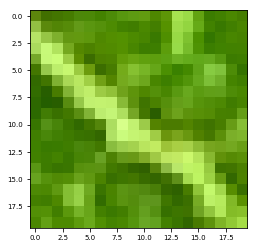

In [93]:
XE, YE = gen_color_lattice(0.4, 0.4, 0.2, 15.00, 0.4)
# plot colored E
plt.imshow(s_gen_color)

# shift mosaic to fit in plot
#scaleR = [9.5]*len(XE[0])
#scaleG = [9.5]*len(XE[1])
#scaleB = [9.5]*len(XE[2])
# plot mosaic
#plt.scatter(XE[0]+scaleR, YE[0]+scaleR, color='red', alpha=0.5)
#plt.scatter(XE[1]+scaleG, YE[1]+scaleG, color='green', alpha=0.5)
#plt.scatter(XE[2]+scaleB, YE[2]+scaleB, color='blue', alpha=0.5)
#s_gen = s_gen.reshape(l_i*l_i,)

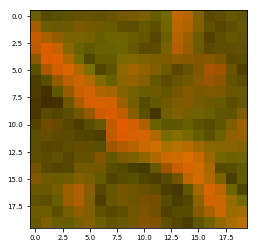

In [94]:
# FOR COLOR OPPONENCY
# Black-white -> L+M+S
# Red-green -> L+M
# Blue-yellow -> (L+M)-S

# transform RGB to LCC
LCC = np.array(([0.299, 0.587, 0.114], [0.5, 0.5, -1.0], [0.866, -0.866, 0.0]))
theta_0 = np.zeros((l_i, l_i))
color_opponency = np.zeros((l_i, l_i, 3))
for i in range(0, l_i):
    for j in range(0, l_i):
        color_opponency[i,j,:] = LCC.dot(s_gen_color[i,j,:])
        theta = np.arctan2(color_opponency[i,j,2], color_opponency[i,j,1])
        if (theta < np.pi/3.0):
            theta_0[i,j] = (3.0/2.0)*theta
        elif (theta > np.pi/3.0) and (theta < np.pi):
            theta_0[i,j] = np.pi/2.0 + (3.0/4.0)*(theta-np.pi/3.0)
        c, s = np.cos(theta_0[i,j]-theta), np.sin(theta_0[i,j]-theta)
        R = np.array(((c,-s), (s, c)))
        color_opponency[i,j,1:3] = R.dot(color_opponency[i,j,1:3])
        
#yb_range = np.max(color_opponency[:,:,1]) - np.min(color_opponency[:,:,1])
#rg_range = np.max(color_opponency[:,:,2]) - np.min(color_opponency[:,:,2])
#color_opponency[:,:,1] = (color_opponency[:,:,1] - np.min(color_opponency[:,:,1])) / yb_range
#color_opponency[:,:,2] = (color_opponency[:,:,2] - np.min(color_opponency[:,:,2])) / rg_range
color_opponency[:,:,0][color_opponency[:,:,0] < 0] = 0
color_opponency[:,:,0][color_opponency[:,:,0] > 1] = 1
color_opponency[:,:,1][color_opponency[:,:,1] < -1] = -1
color_opponency[:,:,1][color_opponency[:,:,1] > 1] = 1
color_opponency[:,:,2][color_opponency[:,:,2] < -1] = -1
color_opponency[:,:,2][color_opponency[:,:,2] > 1] = 1

plt.imshow(color_opponency)

(-0.5, 19.5, 19.5, -0.5)

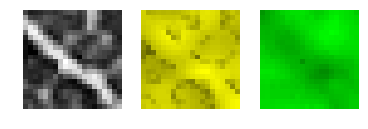

In [95]:
l = np.copy(color_opponency[:,:,0])
#plt.imshow(l)

#blue-yellow visualization
b = np.copy(color_opponency[:,:,1])
y = np.copy(b)
y[y < 0] = 0
b[b > 0] = 0
if np.max(y) <> 0:
    y = y/np.max(y)
if np.min(b) <> 0:    
    b = b/np.min(b)
by = np.dstack((y,y,b))
#plt.imshow(by)

#red-green visualization
r = np.copy(color_opponency[:,:,2])
g = np.copy(r)
r[r < 0] = 0
g[g > 0] = 0
if np.max(r) <> 0:
    r = r/np.max(r)
if np.min(g) <> 0:
    g = g/np.min(g)
b = np.zeros((l_i,l_i))
rg = np.dstack((r,g,b))
#plt.imshow(rg)

fig, ax = plt.subplots(1,3)
ax[0].imshow(l)
ax[1].imshow(by)
ax[2].imshow(rg)
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')

In [ ]:
%%time
#s_gen_color.shape
#s_gen = s_gen_color[:,:,0] #1st run
#s_gen = s_gen_color[:,:,1] #2nd run
#s_gen = s_gen_color[:,:,2] #3rd run
#s_gen = s_gen.reshape(l_i*l_i,)
#plt.imshow(s_gen.reshape(l_i, l_i))
pg = EMGauss.init_path_generator(motion_gen={'mode': 'Diffusion', 'dc': 4.}, n_t=n_t, dt=dt)
path = pg.gen_path()
#path = path*0.0 # no motion
#tests = ['redgreen', 'redgreen', 'blue']
opponency_tests = ['', '', 'redgreen']
data_ = [[],[],[]]

#color_opponency = np.dstack((color_opponency[:,:,0], color_opponency[:,:,1], 
#                             color_opponency[:,:,1], color_opponency[:,:,2], color_opponency[:,:,2]))
#data_ = [[],[],[],[],[]]
#opponency_tests = ['', 'redgreen', 'blue', 'red', 'green']

for i in range(0,color_opponency.shape[2]):
    print 'Run #', i
    s_gen = color_opponency[:,:,i].reshape(l_i*l_i,)
    #s_gen = s_gen_color[:,:,i].reshape(l_i*l_i,)
    
    emg = EMGauss(
        test=opponency_tests[i],
        #test=tests[i],
        l_i=l_i, 
        motion_gen={'mode': 'Diffusion', 'dc': 4.},
        motion_prior={'dc': 10.},
        n_t=n_t,
        ds=ds,
        de=de,
        dt=dt,
        n_p=50,
        print_mode=True,
        l_n=l_n,
        rf_ratio=rf_ratio,
        sig_obs=0.1,
        r=0.45,
        g=0.45,
        b=0.1,
        neuron_layout='hex_color'
    )
    
    emg.pg = pg;
    
    n_repeats = 2

    for _ in range(n_repeats):
        #m, xr, yr = emg.gen_data(s_gen)
        m, xr, yr = emg.gen_data(s_gen, pg, path)
        s, s_est_ = emg.run_em(m, n_passes=1, n_itr=n_t, reg=1.)
        emg.pf.calculate_means_sdevs()

        means = emg.pf.means.copy()
        sdevs = emg.pf.sdevs.copy()


        data_[i].append(
            {
                'm': m,
                'xr': xr,
                'yr': yr,
                's': s,
                's_est_': s_est_,
                'means': means,
                'sdevs': sdevs
            })
    
    with emg.tb.sess.as_default():
        xe, ye = emg.tb.sess.run([emg.tb.t_xe, emg.tb.t_ye])
        xs, ys = emg.tb.sess.run([emg.tb.t_xs, emg.tb.t_ys])
    
    if i == 0:
        stotal = [[],[],[]]
        #stotal = [[],[],[],[],[]]
    
    stotal[i] = s
    
    if i == 2:
        scolor = np.dstack((stotal[0].reshape(l_i,l_i), stotal[1].reshape(l_i,l_i),stotal[2].reshape(l_i,l_i)))
        #plt.imshow(scolor)
    

Run # 0
Run # 1
Run # 2


In [ ]:
#plt.scatter(emg.xe[0],emg.ye[0], color='red')
#plt.scatter(emg.xe[1],emg.ye[1], color='green')
#plt.scatter(emg.xe[2],emg.ye[2], color='blue')
#plt.scatter(xs,ys, alpha=0.4)
#plt.show()
#scolor = np.dstack(((1.0/np.sqrt(3))*stotal[0].reshape(l_i,l_i), 
#                    (1.0/np.sqrt(2))*(stotal[1].reshape(l_i,l_i) - 2*stotal[2].reshape(l_i,l_i)), 
#                    (1.0/np.sqrt(2))*(stotal[3].reshape(l_i,l_i) - stotal[4].reshape(l_i,l_i))))

# change from opponency to RGB
RGB = np.array(([1.0, 0.114, 0.7436], [1.0, 0.114, -0.4111], [1.00, -0.886, 0.1663]))
theta_inv = np.zeros((l_i, l_i))
sgen_rgb = np.zeros((l_i, l_i, 3))
#scolor[:,:,1] = scolor[:,:,1] + scolor[:,:,0] - scolor[:,:,2]
#scolor[:,:,2] = scolor[:,:,0] - scolor[:,:,2]
for i in range(0, l_i):
    for j in range(0, l_i):
        theta_0 = np.arctan2(scolor[i,j,2], scolor[i,j,1])
        if (theta_0 < np.pi/2.0):
            theta_inv[i,j] = (2.0/3.0)*theta_0
        elif (theta_0 > np.pi/2.0) and (theta_0 < np.pi):
            theta_inv[i,j] = np.pi/3.0 + (4.0/3.0)*(theta_0-np.pi/2.0)
        c, s = np.cos(theta_inv[i,j]-theta_0), np.sin(theta_inv[i,j]-theta_0)
        R = np.array(((c,-s), (s, c)))
        sgen_rgb[i,j,1:3] = R.dot(scolor[i,j,1:3])
        sgen_rgb[i,j,:] = RGB.dot(scolor[i,j,:])

sgen_rgb[sgen_rgb < 0] = 0        
sgen_rgb[sgen_rgb > 1] = 1
        
from src.gauss_plots import smooth_image
sr = smooth_image(sgen_rgb[:,:,0])
sg = smooth_image(sgen_rgb[:,:,1])
sb = smooth_image(sgen_rgb[:,:,2])
sgen_smooth = np.dstack((sr,sg,sb))

plt.imshow(sgen_smooth)

In [ ]:
#plt.scatter(xr,yr)
#plt.scatter(xs,ys, color='blue', alpha=0.2)
#plt.scatter(xe,ye, color='red', alpha=0.2)

# 1st run
#stotal = [[],[],[]]
#stotal[0] = s
# 2nd run
#stotal[1] = s 
# 3rd run
#stotal[2] = s
#scolor = np.dstack((stotal[0].reshape(l_i,l_i), stotal[1].reshape(l_i,l_i),stotal[2].reshape(l_i,l_i)))
#plt.imshow(scolor)

In [ ]:
for i in range(0,3):
    for d in data_[i]:
        #d['snr_list'] = get_snr_list(s_gen, d['s_est_'], (d['xr'], d['yr']), d['means'], xs, ys, ds)
        d['snr_list'] = get_snr_list(s_gen_color[:,:,i], d['s_est_'], (d['xr'], d['yr']), d['means'], xs, ys, ds)

In [ ]:
from src.gauss_plots import smooth_image

def plot_image(fig, ax, s, ds, colorbar=False, alpha=1.,
                    cmap=plt.cm.gray, title='', vmin=None, vmax=None):
    """
    Plot the image.

    Parameters
    ----------
    fig : plt.Figure
        Figure
    ax : plt.Axes
        Axes to plot image
    s : array, shape (l_i, l_i)
        Unraveled image to be plotted.
    ds : float
        Spacing between pixels.
    colorbar : bool
        If true, show a colorbar.
    alpha : float
        Alpha for showing image.
    cmap : plt.cm
        Colormap.
    title : str
        String for the title.
    vmin, vmax : float
        Min and max for imshow.
    """
    s1 = smooth_image(s)
    l_i = s.shape[0]
    if vmin is None:
        vmin = s.min()
    if vmax is None:
        vmax = s.max()
    a = ds * l_i / 2
    im = ax.imshow(
        s1, cmap=cmap, interpolation='gaussian',
        extent=[-a, a, -a, a], alpha=alpha,
        vmin=vmin, vmax=vmax)
    ax.set_title(title, fontsize=FONTSIZE)
    if colorbar:
        fig.colorbar(im, ax=ax)



def plot_fourier_spectrum(fig, ax, s, ds, de):
    """
    Plot the fourier spectrum.

    Parameters
    ----------
    fig : plt.Figure
        Figure for plotting
    ax : plt.axes
        Plotting axes.
    s : array, shape (l_i, l_i)
        Image to get the fourier transform of.
    ds : float
        Spacing of the pixels.
    de : float
        Spacing of Receptive fields.
    """
    s1 = smooth_image(s)
    l_i = s.shape[0]
    ax.set_title('Fourier Transform', fontsize=FONTSIZE)
    freqs = np.fft.fftshift(np.fft.fftfreq(l_i)) / ds
    df = (freqs[1] - freqs[0])
    fmin = freqs[0] - df / 2
    fmax = freqs[-1] + df / 2
    im = ax.imshow(np.abs(np.fft.fftshift(np.fft.fft2(s1))),
               extent=[fmin, fmax, fmin, fmax],
               cmap=plt.get_cmap('afmhot'))
    fn = 0.5 * de
    ax.add_patch(plt.Circle((0, 0), fn, color='gray', alpha=0.5))
    ax.add_patch(plt.Circle((0, 0), fn / (np.sqrt(3.) / 2.), color='gray', alpha=0.25))
    fig.colorbar(im, ax=ax)



def compare_fourier(s_gen, s_inf, snr_list, l_i, ds, de, 
             xe, ye, rf_ratio):
    """ 
    Plot the two fourier spectrums.

    Parameters
    ----------
    s_gen : array, shape (l_i, l_i)
      Image that generated the observations.
    s_inf : array, shape (l_i, l_i)
      Inferred image.
    ds : float
      Spacing between pixels.
    de : float
      Spacing between receptors.
    xe, ye : array, shape (n_sensors,)
      X, Y positions of sensors.
    """
    n_row, n_col = 2, 3
    fig, axes = plt.subplots(nrows=n_row, ncols=n_col, 
                        figsize=(n_col * 7/3., n_row * 2))
    vmin, vmax = s_gen.min(), s_gen.max()

    for i, (s, name) in enumerate(zip([s_gen, s_inf], ['Original', 'Estimate'])):
        ax = axes[i][0]
        plot_image(fig, ax, s, ds=ds, title='Image: {}'.format(name),
                 vmin=vmin, vmax=vmax)

        ax = axes[i][1]
        plot_fourier_spectrum(fig, ax, s, ds, de) 

    ax = axes[0][2]
    plot_rfs(ax, xe, ye, de, rf_ratio, alpha=0.5)
    plot_image(
      fig, ax, s_gen, ds=ds,
      title='Image: {}'.format('Image with RFs')
    )

    ax = axes[1][2]
#     ax.plot(snr_list)
    ax.set_title('SNR as a function of time', fontsize=FONTSIZE)
    return fig, axes

In [ ]:
from src.analyzer import plot_fill_between

In [ ]:
snrs = [[],[],[]]
for i in range(0,3):
    snrs[i] = np.array([d['snr_list'] for d in data_[i]])
snrs = snrs[0] + snrs[1] + snrs[2]
snrs /= 3.0

In [ ]:
plt.plot(snrs.T);

In [ ]:
ax = plt.axes()
plot_fill_between(ax, np.arange(snrs.shape[1]), snrs)

In [ ]:
snr_motion = snrs
#snr_nomotion = snrs
#ax = plt.axes()
#plot_fill_between(ax, np.arange(snr_nomotion.shape[1]), snr_nomotion)
#plot_fill_between(ax, np.arange(snr_motion.shape[1]), snr_motion)
#data_[0][0].keys()

In [ ]:
#fig, axes = compare_fourier(
#    scolor[:,:,0].reshape(l_i, l_i), 
#    data_[0]['s_est_'][-1].reshape(l_i, l_i), 
#    data_[0]['snr_list'], 
#    l_i, ds, de, xe, ye, rf_ratio)
#ax = axes[1][2]
#plot_fill_between(ax, np.arange(snrs.shape[1]), snrs)
#plt.savefig('gauss_super_res.pdf')

In [ ]:
#plt.figure(figsize=(10, 4))
#for d in range(2):
#    plt.subplot(1, 2, d + 1)
#    plot_path_estimate(data_[0]['means'], data_[0]['sdevs'], (xr, yr), d=d, q=100)

In [ ]:
#plt.imshow(s_gen.reshape(l_i, l_i))
#plt.colorbar()